In [2]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\xiaoke\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\pyth

In [4]:
# Build and train a network.

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
#mnist = read_data_sets("E:\WithWeng\DeepExplain\data", one_hot=True)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax')) 
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2447 - acc: 0.9246 - val_loss: 0.0556 - val_acc: 0.9813

In [5]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test[0:10]
    ys = y_test[0:10]
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    #attributions_sal   = de.explain('saliency', target_tensor, input_tensor, xs, ys=ys)
    #attributions_ig    = de.explain('intgrad', target_tensor, input_tensor, xs, ys=ys)
    #attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    #attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)
    #attributions_occ   = de.explain('occlusion', target_tensor, input_tensor, xs, ys=ys)
    
    # Compare Gradient * Input with approximate Shapley Values
    # Note1: Shapley Value sampling with 100 samples per feature (78400 runs) takes a couple of minutes on a GPU.
    # Note2: 100 samples are not enough for convergence, the result might be affected by sampling variance
    attributions_sv     = de.explain('shapley_sampling', target_tensor, input_tensor, xs, ys=ys, samples=100)

Wall time: 6min 55s


AttributeError: 'AxesImage' object has no property 'axis'

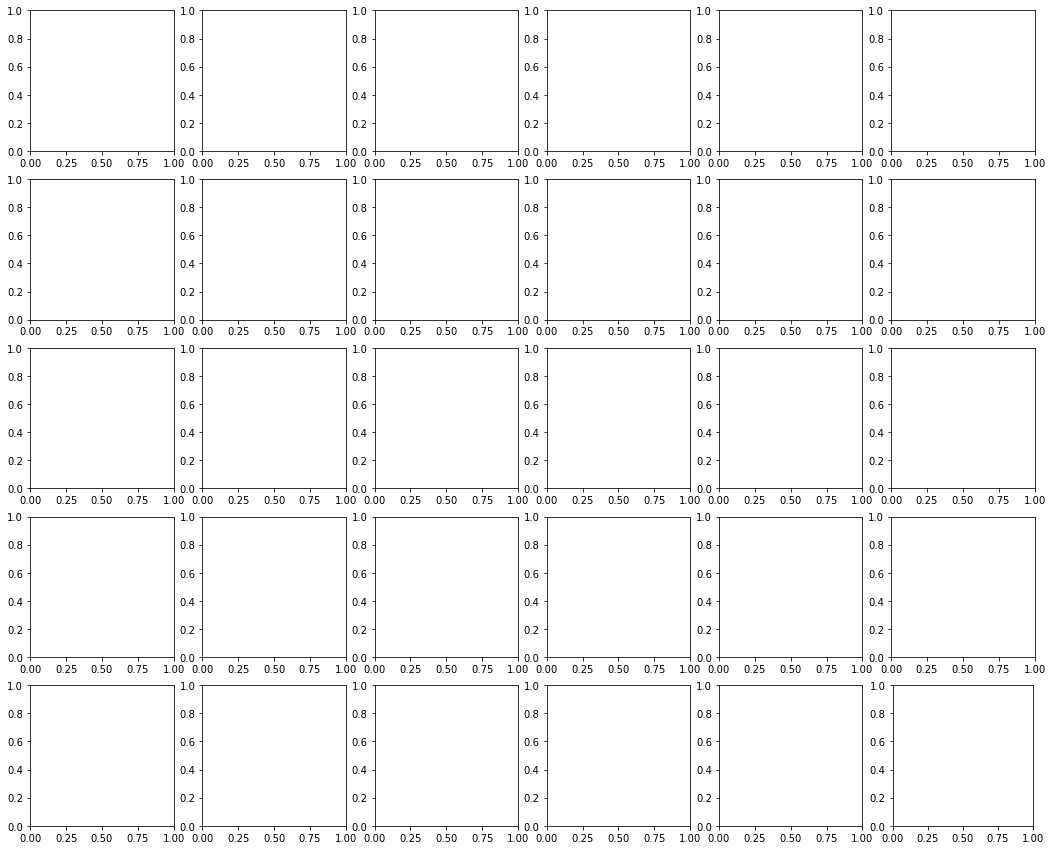

In [6]:
%%time
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.colors import ListedColormap
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_gradin) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_gradin, attributions_sv)):
    row, col = divmod(i, 2)
    #plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plt.imshow(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    #plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    plt.imshow(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('Grad*Input')
    #plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')
    plt.imshow(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('Shapley Values')
    plt.show()

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [7]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test
    ys = y_test
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print ("Done")

Done
Wall time: 9.5 s


In [ ]:
x_test

In [ ]:
y_test